In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct,text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date=session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

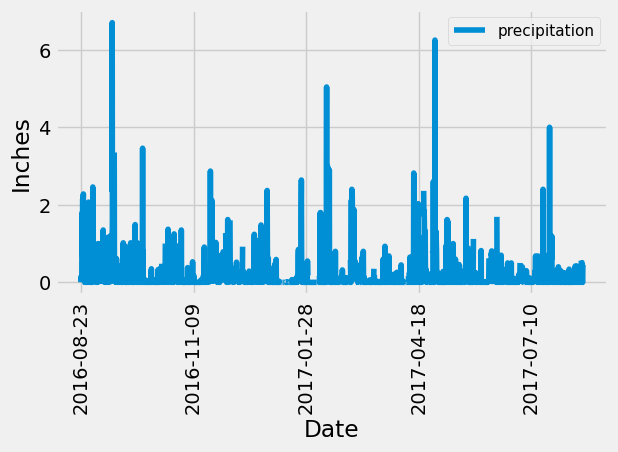

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date

# Calculate the date one year from the last date in data set.
year, month, day = most_recent_date.split('-')
one_year_ago = f"{int(year) - 1}-{month}-{day}"

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= func.date(most_recent_date, '-1 year')
).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
df_sorted = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot(x='date', y='prcp', kind='line',label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90) 
plt.legend(loc='upper right',fontsize=11)
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats_df = pd.DataFrame(df_sorted['prcp'].describe())
summary_stats_df.columns = ['precipitation']
summary_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
[(total_stations,)]

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('observation_count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_stations
# for station, count in most_active_stations:
#     print(f"{station},{count}")

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0]
temperature = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_station_id[0])
    .first()
)
[temperature]


[(54.0, 85.0, 71.66378066378067)]

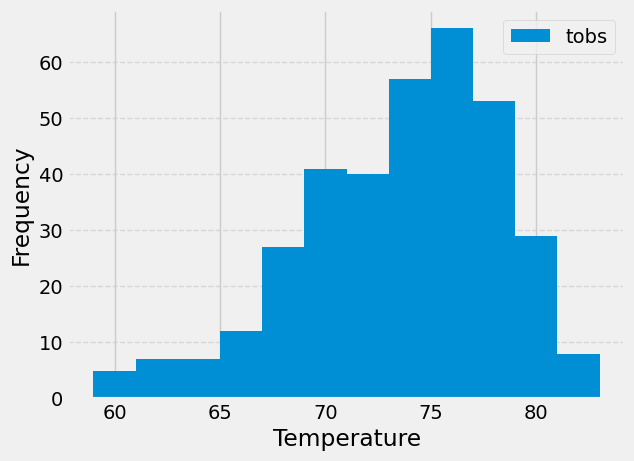

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data=session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id[0]).filter(Measurement.date >= one_year_ago).all()
c_data = [value[0] for value in data]
plt.hist(c_data, bins=12,label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc='upper right',fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()